**Lets flip together**

#### Rotary Positional Encoding


The influence of one token on another is quantified by queries and keys. Can we instead augment these with positional embeddings ? Without modifying the mgnitude of the vector, can we encode positional information? 

**RoPE**: applies rotation in the ($Q$, $K$) embedding space based on the token’s position. Fundamental ideas is to apply sin and cosine positional encoding ot $Q$ and $K$


![RoPE](media/RoPE.jpg)

**But why do we group them into two?**

RoPE groups embeddings into pairs so each can be rotated in a 2D plane.


* **Rotation only makes sense in two dimensions:** To rotate, we need an (x, y) pair. Grouping the embedding into 2D pairs lets each pair be rotated by a different frequency (angle) depending on its place in the embedding and the token’s position.
* **Maintains periodicity and continuity:** Like sinusoidal PE, RoPE allows the model to learn relative positions and distances, but by literally rotating the embedding in 2D space for each pair.
* **Mathematical efficiency:** This rotation preserves the length (norm) of the vector and encodes the position in the direction (angle) of the embedding in 2D.


**Here is the process**


* **Take the embedding vector** (say of size `d_model`), and **group it into pairs**:

  * $(dim 0, dim 1)$, $(dim 2, dim 3)$, ..., (dim $d_{model-2}$ & dim $d\_{model-1}$)`
* **Each pair** is treated as a complex number:

  * For the $k$th pair: $[x_{2k}, x_{2k+1}]$ → represents real and imaginary components.
* **Apply a rotation** (i.e., multiply by a complex exponential corresponding to the position):

  * For position `pos`, the rotation angle is based on `pos` and the pair index `k`.
  * This is equivalent to:

    $(x', y') = (x \cos(\theta) - y \sin(\theta),\ x \sin(\theta) + y \cos(\theta))$
    

    where `theta` is the rotation angle for that pair at that position.


In [64]:
import torch
import matplotlib.pyplot as plt

In [77]:
b = 2
seq = 512
emb = 256

input_data = torch.rand(b, seq, emb)


pos = torch.arange(seq, dtype=torch.float).unsqueeze(1) # (seq,1)

dimensions = torch.arange(0, emb, 2) # (emb/2) since we will group the emb into pair of two dim

inverse_freq = 1 / (10000 ** (dimensions / emb)) # (emb/2)

theta = pos @ inverse_freq.unsqueeze(0) # (5,4)

sin_theta = torch.sin(theta).unsqueeze(0) # expanding for batch dim
cos_theta = torch.cos(theta).unsqueeze(0) # expanding for batch dim

all_theta = torch.cat([sin_theta, cos_theta], dim=-1)

print(f"Sin:{sin_theta.shape}, Cos:{cos_theta.shape}, All: {all_theta.shape}\n")


x1 = input_data[..., 0::2] # creating first  dim data (x1)
x2 = input_data[..., 1::2]


print(f"X1: {x1.shape}, X2: {x2.shape}")

x1_rot = x1 * cos_theta + x2 * sin_theta
x2_rot = -x1 * sin_theta + x2 * cos_theta

result = torch.stack([x1_rot, x2_rot], dim=-1).view(b, seq,emb)
print(result.shape)


Sin:torch.Size([1, 512, 128]), Cos:torch.Size([1, 512, 128]), All: torch.Size([1, 512, 256])

X1: torch.Size([2, 512, 128]), X2: torch.Size([2, 512, 128])
torch.Size([2, 512, 256])


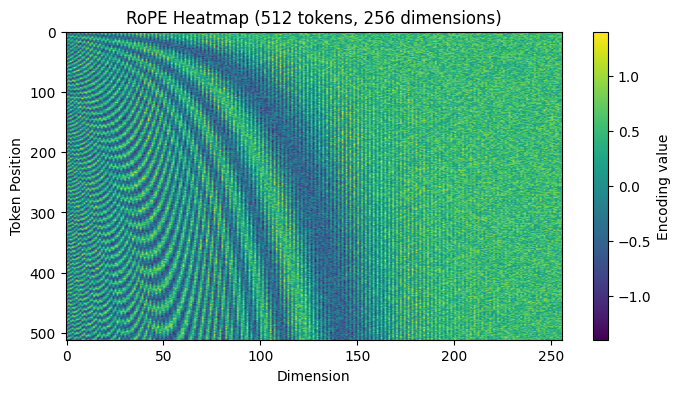

In [78]:

plot_data = result[1]

plt.figure(figsize=(8, 4))
plt.imshow(plot_data, aspect='auto')
plt.colorbar(label='Encoding value')
plt.ylabel('Token Position')
plt.xlabel('Dimension')
plt.title(f'RoPE Heatmap ({seq} tokens, {emb} dimensions)')
plt.show()

In [79]:
class RoPE():
    def __init__(self, seq_len, embedding_dim):
        assert embedding_dim % 2 == 0, "Embedding dim must be even"
        super().__init__()
        self.embedding_dim = embedding_dim
        self.seq_len = seq_len

        positions = torch.arange(self.seq_len,dtype=torch.float).unsqueeze(1)
        dimensions = torch.arange(0, self.embedding_dim, 2).unsqueeze(0)

        inv_freq = 1 / (10000 **(dimensions/self.embedding_dim))

        self.theta = positions @ inv_freq #(seq, emb/2)


    def __call__(self, x):
        
        b, _, _ = x.shape 
        
        sin_theta = torch.sin(self.theta).unsqueeze(0) # (b, seq, emb/2)
        cos_theta = torch.cos(self.theta).unsqueeze(0) # (b, seq, emb/2)

        # split x into pairs 
        x1 = x[..., 0::2] # (b, seq, emb/2)
        x2 = x[..., 1::2] # (b, seq, emb/2)

        # rotate with theta and x
        x1_rot = x1 * cos_theta + x2 * sin_theta
        x2_rot = -x1 * sin_theta + x2 * cos_theta

        # stack along the last dime 
        encodings = torch.stack([x1_rot, x2_rot], dim=-1) # (b, seq, emb/2, 2)
        return encodings.view(b, self.seq_len, self.embedding_dim)



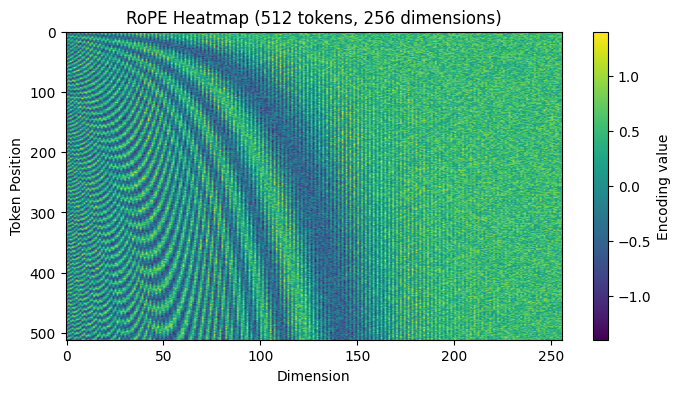

In [80]:

rope = RoPE(seq_len=seq, embedding_dim=emb)
enc = rope(input_data)


plot_data = enc[1]

plt.figure(figsize=(8, 4))
plt.imshow(plot_data, aspect='auto')
plt.colorbar(label='Encoding value')
plt.ylabel('Token Position')
plt.xlabel('Dimension')
plt.title(f'RoPE Heatmap ({seq} tokens, {emb} dimensions)')
plt.show()

Rotary Positional Encoding (RoPE) offers a more effective and elegant alternative to traditional sinusoidal embeddings by encoding relative positional information directly into the attention mechanism. This design enables models to better capture the distance and order between tokens, leading to improved generalization to longer sequences and more position-aware attention. Without introducing additional parameters, RoPE enhances both the expressiveness and efficiency of transformer models, making it a preferred choice in many modern architectures.


| Feature                    | Sinusoidal PE          | RoPE                          |
| -------------------------- | ---------------------- | ----------------------------- |
| Type                       | Absolute               | Relative                      |
| Used in Attention?         | No                     | Yes (Q, K rotation)           |
| Generalizes to long seqs   | Yes                    | Better                        |
| Parameters                 | None                   | None                          |
| Integrates with attention  | Indirectly             | Directly affects attention    |
| Relative position modeling | Weak (via subtraction) | Strong (via rotation algebra) |
